In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from datetime import datetime
import time
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
data  = pd.read_csv('../Data/earthquake_dataset.csv')
data.head()

,Time,Latitude,Longitude,Depth/Km,Magnitude,EventLocationName
0,2010-10-13T21:41:46.570000,42.623,12.756,10.5,1.7,3 km W Ferentillo (TR)
1,2010-10-13T21:43:14.530000,42.457,13.390,10.8,1.7,8 km E Pizzoli (AQ)
2,2010-10-13T23:35:35.700000,42.470,13.377,11.0,0.8,8 km E Pizzoli (AQ)
3,2010-10-13T23:44:28.160000,42.474,13.393,12.9,1.3,9 km E Pizzoli (AQ)
4,2010-10-13T23:46:11.610000,42.448,13.387,10.2,2.0,8 km E Pizzoli (AQ)


## Feature engineering

In [3]:
dates = [datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f') for x in data['Time']]
time_s = [int(time.mktime(d.timetuple()) / (60*60*24)) for d in dates]  # days since epoch

data['Time/d'] = time_s

# select features
features = ['Latitude', 'Longitude', 'Depth/Km', 'Magnitude', 'Time/d'] # 'Year', 'Month', 'Day']#, 'Hour']
data[features].head()

,Latitude,Longitude,Depth/Km,Magnitude,Time/d
0,42.623,12.756,10.5,1.7,14895
1,42.457,13.390,10.8,1.7,14895
2,42.470,13.377,11.0,0.8,14895
3,42.474,13.393,12.9,1.3,14895
4,42.448,13.387,10.2,2.0,14895


In [4]:
data = data[features]
labels = []
for index, row in data.iterrows():
    day = row['Time/d']
    # next five days
    next_five_days = (data['Time/d'] > day) & (data['Time/d'] <= day+5)
    tmp = data[next_five_days]
    # earthquake with magnitude greater than 3
    tmp = tmp[tmp['Magnitude'] >= 3]
    # create label
    if len(tmp > 0):
        labels.append(1)
    else:
        labels.append(0)
        
data['label'] = labels

In [5]:
len(data[data['label']==1])

11427

In [6]:
data.head()

,Latitude,Longitude,Depth/Km,Magnitude,Time/d,label
0,42.623,12.756,10.5,1.7,14895,0
1,42.457,13.390,10.8,1.7,14895,0
2,42.470,13.377,11.0,0.8,14895,0
3,42.474,13.393,12.9,1.3,14895,0
4,42.448,13.387,10.2,2.0,14895,0


In [73]:
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(data.label)

Y_data = np_utils.to_categorical(encoded_Y)
Y_data.shape

(29969, 2)

In [62]:
#Y_data = np.reshape(Y_data, (1,29969,2))
#Y_data.shape

(1, 29969, 2)

## Create dataset

In [8]:
X_data = data[features].values
X_data.shape

(29969, 5)

#### Preprocessing

In [134]:
standardizer = MinMaxScaler()
X_data = standardizer.fit_transform(X_data)

#### Train / Validation / Test split

In [135]:
# split between train and validation
tr_size = int(0.7 * len(X_data))
vl_size = int(0.2 * len(X_data))
ts_size = int(0.1 * len(X_data))

X_data_train, X_data_val, X_data_test = X_data[:tr_size,:], X_data[tr_size:tr_size+vl_size,:], X_data[-ts_size:,:]
Y_data_train, Y_data_val, Y_data_test = Y_data[:tr_size,:], Y_data[tr_size:tr_size+vl_size,:], Y_data[-ts_size:,:]

print(X_data_train.shape, Y_data_train.shape)

((20978, 5), (20978, 2))


In [136]:
def create_dataset(dataset, labels, look_back=1):
    """
    creates pairs of past 'look_back' sequences and next target sequence
    """
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        sequences = dataset[i:(i+look_back)]
        target_sequence = labels[i + look_back]
        X.append(np.array(sequences))
        Y.append(np.array(target_sequence))
        
    return np.array(X), np.array(Y)

In [137]:
look_back = 50

X_train, Y_train = create_dataset(X_data_train, Y_data_train, look_back)
X_val, Y_val = create_dataset(X_data_val, Y_data_val, look_back)
X_test, Y_test = create_dataset(X_data_test, Y_data_test, look_back)

print X_train.shape, Y_train.shape
print X_val.shape, Y_val.shape

(20927, 50, 5) (20927, 2)
(5942, 50, 5) (5942, 2)


### Training callbacks

In [13]:
filepath = 'model.{epoch:02d}-{val_loss:.5f}.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)

# Model definition

In [151]:
n_inputs = X_train.shape[2]
n_outputs = Y_train.shape[1]

print n_inputs, n_outputs

model = Sequential()

model.add(LSTM(
    input_dim=n_inputs,
    output_dim=200,
    return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(
    output_dim=100,
    return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(
    output_dim=50,
    return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(units=n_outputs, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

5 2


/home/carlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/carlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=200, return_sequences=True, input_shape=(None, 5))`
  # This is added back by InteractiveShellApp.init_path()
/home/carlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=100, return_sequences=True)`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, None, 200)         164800    
_________________________________________________________________
dropout_122 (Dropout)        (None, None, 200)         0         
_________________________________________________________________
lstm_55 (LSTM)               (None, None, 100)         120400    
_________________________________________________________________
dropout_123 (Dropout)        (None, None, 100)         0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_124 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 512)               26112     
__________

/home/carlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=False)`


In [152]:
epochs = 40
batch_size = 32
actual_tr_size = 3000 # actual training set size
actual_vl_size = 200

#Y_train = np.reshape(Y_train, (1,Y_train.shape[0], Y_train.shape[1]))

history = model.fit(X_train[-actual_tr_size:], Y_train[-actual_tr_size:],
                    batch_size=batch_size,
                    verbose=1, 
                    callbacks=[model_checkpoint],
                    epochs=epochs,
                    validation_data=(X_val[:actual_vl_size], Y_val[:actual_vl_size]),
                    shuffle=False,
                    initial_epoch=0)

Train on 3000 samples, validate on 200 samples
Epoch 1/40
3000/3000 [==============================] - 44s 15ms/step - loss: 0.4235 - acc: 0.8800 - val_loss: 0.7393 - val_acc: 0.8850
Epoch 2/40
3000/3000 [==============================] - 41s 14ms/step - loss: 0.3963 - acc: 0.8877 - val_loss: 0.6957 - val_acc: 0.8850
Epoch 3/40
3000/3000 [==============================] - 44s 15ms/step - loss: 0.3950 - acc: 0.8930 - val_loss: 0.6270 - val_acc: 0.8850
Epoch 4/40
3000/3000 [==============================] - 43s 14ms/step - loss: 0.3887 - acc: 0.8953 - val_loss: 0.6035 - val_acc: 0.8850
Epoch 5/40
3000/3000 [==============================] - 43s 14ms/step - loss: 0.3724 - acc: 0.8993 - val_loss: 0.6322 - val_acc: 0.8850
Epoch 6/40
3000/3000 [==============================] - 41s 14ms/step - loss: 0.3534 - acc: 0.9000 - val_loss: 0.6443 - val_acc: 0.8850
Epoch 7/40
3000/3000 [==============================] - 43s 14ms/step - loss: 0.3530 - acc: 0.9113 - val_loss: 0.6621 - val_acc: 0.8850
E

### Learning curve plot

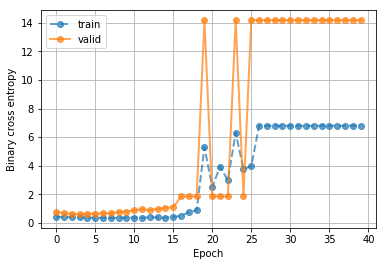

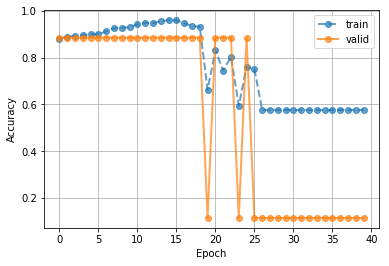

In [155]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(loss, linewidth=2, label='train', linestyle='--', marker='o', alpha=0.7)
plt.plot(val_loss, linewidth=2, label='valid', marker='o', alpha=0.7)
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Binary cross entropy')

plt.show()

plt.plot(acc, linewidth=2, label='train', linestyle='--', marker='o', alpha=0.7)
plt.plot(val_acc, linewidth=2, label='valid', marker='o', alpha=0.7)
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

## Test set evaluation

In [148]:
print 'Test set error/accuracy:', model.evaluate(X_test, Y_test)

2945/2945 [==============================] - 9s 3ms/step
 [12.432281970232658, 0.22444821731748726]
